# Homework 2 - Berkeley STAT 157

Handout 1/29/2019, due 2/5/2019 by 4pm in Git by committing to your repository.

In [1]:
import torch

# 1. Multinomial Sampling

Implement a sampler from a discrete distribution from scratch, mimicking the function `mxnet.ndarray.random.multinomial`. Its arguments should be a vector of probabilities $p$. You can assume that the probabilities are normalized, i.e. tha they sum up to $1$. Make the call signature as follows:

```
samples = sampler(probs, shape) 

probs   : An ndarray vector of size n of nonnegative numbers summing up to 1
shape   : A list of dimensions for the output
samples : Samples from probs with shape matching shape
```

Hints:

1. Use `mxnet.ndarray.random.uniform` to get a sample from $U[0,1]$.
1. You can simplify things for `probs` by computing the cumulative sum over `probs`.

In [2]:
def sampler(probs, shape):
    result = torch.zeros(shape)
    p = torch.distributions.uniform.Uniform(torch.zeros(shape), torch.ones(shape)).sample()  # 均匀分布
    sum_prob = 0
    for prob in probs:
        sum_prob += prob
        result += torch.ge(p, sum_prob)
    return result

# a simple test
sampler(torch.tensor([0.2, 0.3, 0.5]), (2,3))

tensor([[1., 1., 2.],
        [1., 2., 2.]])

# 2. Central Limit Theorem

Let's explore the Central Limit Theorem when applied to text processing. 

* Download [https://www.gutenberg.org/ebooks/84](https://www.gutenberg.org/files/84/84-0.txt) from Project Gutenberg 
* Remove punctuation, uppercase / lowercase, and split the text up into individual tokens (words).
* For the words `a`, `and`, `the`, `i`, `is` compute their respective counts as the book progresses, i.e. 
    $$n_\mathrm{the}[i] = \sum_{j = 1}^i \{w_j = \mathrm{the}\}$$
* Plot the proportions $n_\mathrm{word}[i] / i$ over the document in one plot.
* Find an envelope of the shape $O(1/\sqrt{i})$ for each of these five words. (Hint, check the last page of the [sampling notebook](http://courses.d2l.ai/berkeley-stat-157/slides/1_24/sampling.pdf))
* Why can we **not** apply the Central Limit Theorem directly? 
* How would we have to change the text for it to apply? 
* Why does it still work quite well?

In [3]:
import os
import wget
import string

os.makedirs(os.path.join('data'), exist_ok=True)
if not os.path.exists(os.path.join("data", "84-0.txt")):
    wget.download("https://www.gutenberg.org/files/84/84-0.txt", "data/84-0.txt") 

with open("data/84-0.txt") as f:
    book = f.read()
    
exclude = set(string.punctuation)
out = ''.join(ch for ch in book if ch not in exclude)  # 删除标点

tokens = out[1:].lower().split( )  # 全部小写并分割空格和换行

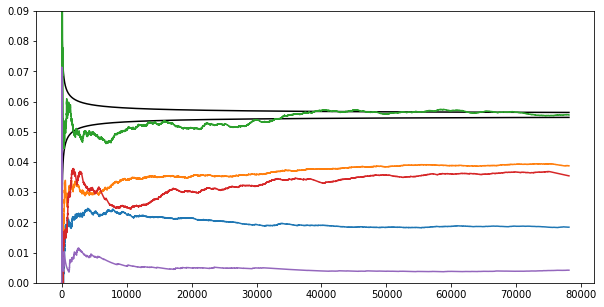

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

tokens = np.array(tokens)
plt.figure(figsize=(10,5))
words = ['a', 'and', 'the', 'i', 'is']
for word in words:
    x = (tokens == word)
    mean = np.mean(x)
    variance = mean * (1 - mean)
    y = np.arange(1, len(x)+1)
    if word == 'the':
        plt.plot(y,(variance**0.5) * np.power(y,-0.5) + mean,'black')
        plt.plot(y,-(variance**0.5) * np.power(y,-0.5) + mean,'black')
    z = np.cumsum(x)/y
    plt.plot(y,z)
plt.ylim(0, .09)

#plt.legend(words)
plt.show()

- Why can we not apply the Central Limit Theorem directly?
> The subsequent proportions are not independant of each other. For example, the next value has either the same number or the same number + 1 sucesses as last value.

- How would we have to change the text for it to apply?
> Have each x value be an independant sample from the corpus of words where we measure the proportion of a certain word. So we could randomize the text before we calculate each p.

- Why does it still work quite well?
> We converge to the actual probability since the first half of the corpus proportion is a really good estimate for the second half of the corpus.

## 3. Denominator-layout notation

We used the numerator-layout notation for matrix calculus in class, now let's examine the denominator-layout notation.

Given $x, y\in\mathbb R$, $\mathbf x\in\mathbb R^n$ and $\mathbf y \in \mathbb R^m$, we have

$$
\frac{\partial y}{\partial \mathbf{x}}=\begin{bmatrix}
\frac{\partial y}{\partial x_1}\\
\frac{\partial y}{\partial x_2}\\
\vdots\\
\frac{\partial y}{\partial x_n}
\end{bmatrix},\quad 
\frac{\partial \mathbf y}{\partial {x}}=\begin{bmatrix}
\frac{\partial y_1}{\partial x}, 
\frac{\partial y_2}{\partial x}, 
\ldots,
\frac{\partial y_m}{\partial x}
\end{bmatrix}
$$

and 

$$
\frac{\partial \mathbf y}{\partial \mathbf{x}}
=\begin{bmatrix}
\frac{\partial \mathbf y}{\partial {x_1}}\\
\frac{\partial \mathbf y}{\partial {x_2}}\\
\vdots\\
\frac{\partial \mathbf y}{\partial {x_3}}\\
\end{bmatrix}
=\begin{bmatrix}
\frac{\partial y_1}{\partial x_1}, 
\frac{\partial y_2}{\partial x_1},
\ldots,
\frac{\partial y_m}{\partial x_1}
\\ 
\frac{\partial y_1}{\partial x_2},
\frac{\partial y_2}{\partial x_2},
\ldots,
\frac{\partial y_m}{\partial x_2}\\ 
\vdots\\
\frac{\partial y_1}{\partial x_n},
\frac{\partial y_2}{\partial x_n},
\ldots,
\frac{\partial y_m}{\partial x_n}
\end{bmatrix}
$$

Questions: 

1. Assume $\mathbf  y = f(\mathbf u)$ and $\mathbf u = g(\mathbf x)$, write down the chain rule for $\frac {\partial\mathbf  y}{\partial\mathbf x}$
2. Given $\mathbf X \in \mathbb R^{m\times n},\ \mathbf w \in \mathbb R^n, \ \mathbf y \in \mathbb R^m$, assume $z = \| \mathbf X \mathbf w - \mathbf y\|^2$, compute $\frac{\partial z}{\partial\mathbf w}$.

针对数组，列向量和行向量反过来了，做个转置就行了（数组被看成是行向量）

正常情况下还是用分子布局，即数组看成列向量

## 4. Numerical Precision

Given scalars `x` and `y`, implement the following `log_exp` function such that it returns 
$$-\log\left(\frac{e^x}{e^x+e^y}\right)$$.

In [5]:
def log_exp(x, y):
    return -torch.log(torch.exp(x) / (torch.exp(x) + torch.exp(y)))

Test your codes with normal inputs:

In [6]:
x, y = torch.tensor([2.]), torch.tensor([3.])
z = log_exp(x, y)
z

tensor([1.3133])

Now implement a function to compute $\partial z/\partial x$ and $\partial z/\partial y$ with `autograd`

In [7]:
def grad(forward_func, x, y): 
    x.requires_grad_(True)
    y.requires_grad_(True)
    z = forward_func(x, y)
    z.backward()
    print('x.grad =', x.grad)
    print('y.grad =', y.grad)
    x.grad.zero_()
    y.grad.zero_()

Test your codes, it should print the results nicely. 

In [8]:
grad(log_exp, x, y)

x.grad = tensor([-0.7311])
y.grad = tensor([0.7311])


But now let's try some "hard" inputs

In [9]:
x, y = torch.tensor([50.]), torch.tensor([100.])
grad(log_exp, x, y)

x.grad = tensor([nan])
y.grad = tensor([nan])


Does your code return correct results? If not, try to understand the reason. (Hint, evaluate `exp(100)`). Now develop a new function `stable_log_exp` that is identical to `log_exp` in math, but returns a more numerical stable result.

In [10]:
def stable_log_exp(x, y):
    z = torch.max(x, y)
    return -x + z + torch.log(torch.exp(x - z) + torch.exp(y - z))

grad(stable_log_exp, x, y)

x.grad = tensor([-1.])
y.grad = tensor([1.])
